
# American Community Survey 2019 Data Analysis



In [ ]:
#for displaying map
!pip install pyshp

     |████████████████████████████████| 219 kB 5.2 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=6d9865dd3e9a811e19ea4f41ece5b1a5073398594abcd891ef631d30ba5a2f3a
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import shapefile as shp

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Cleaning Data


In [ ]:
# data from https://data.census.gov/cedsci/table?q=american%20community%20survey%202019&tid=ACSST1Y2019.S0101&tp=true
age_df = pd.read_csv("/content/drive/My Drive/ACS_2019/ACS_Age.csv", thousands=',')

cols = age_df.columns
new_cols = ['Labels', 'Total Population', 'Under 5'] + [f'{i}-{i+4}' for i in range(5, 85, 5)] + ['Over 84']
age_df = age_df.iloc[:, 0:21]
age_df = age_df.drop(labels=cols[2], axis=1)
age_df.set_axis(labels=new_cols, axis=1, inplace=True)

age_df.loc[5, 'Labels'] = 'Percent Estimate'
age_df.loc[6, 'Labels'] = 'Percent Margin of Error'
age_df.loc[8, 'Labels'] = 'Male Estimate'
age_df.loc[9, 'Labels'] = 'Male Margin of Error'
age_df.loc[11, 'Labels'] = 'Percent Male Estimate'
age_df.loc[12, 'Labels'] = 'Percent Male Margin of Error'
age_df.loc[14, 'Labels'] = 'Female Estimate'
age_df.loc[15, 'Labels'] = 'Female Margin of Error'
age_df.loc[17, 'Labels'] = 'Percent Female Estimate'
age_df.loc[18, 'Labels'] = 'Percent Female Margin of Error'

# convert estimates to floats
age_df = age_df.iloc[[2, 3, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18]]
age_df.set_index(np.arange(0, 12), inplace=True)
age_df.iloc[0, 1:] = age_df.iloc[0, 1:].str.replace(',', '').astype(float)
age_df.iloc[4, 1:] = age_df.iloc[4, 1:].str.replace(',', '').astype(float)
age_df.iloc[8, 1:] = age_df.iloc[8, 1:].str.replace(',', '').astype(float)

# convert percent strings to floats
percent_pat = "\d+\.\d%"
percent_repl = lambda m: str(round(float(str(m.group(0))[:-1])/100, 3))
age_df.iloc[2, 2:] = age_df.iloc[2, 2:].str.replace(percent_pat, percent_repl, regex=True).astype(float)
age_df.iloc[6, 2:] = age_df.iloc[6, 2:].str.replace(percent_pat, percent_repl, regex=True).astype(float)
age_df.iloc[10, 2:] = age_df.iloc[10, 2:].str.replace(percent_pat, percent_repl, regex=True).astype(float)

# convert margin of error strings to floats
moe_pat = "±.+"
moe_repl = lambda m: str(m.group(0))[1:].replace(',', '')
age_df.iloc[1, 2:] = age_df.iloc[1, 2:].str.replace(moe_pat, moe_repl, regex=True).astype(float)
age_df.iloc[3, 2:] = age_df.iloc[3, 2:].str.replace(moe_pat, moe_repl, regex=True).astype(float)
age_df.iloc[5, 1:] = age_df.iloc[5, 1:].str.replace(moe_pat, moe_repl, regex=True).astype(float)
age_df.iloc[7, 2:] = age_df.iloc[7, 2:].str.replace(moe_pat, moe_repl, regex=True).astype(float)
age_df.iloc[9, 1:] = age_df.iloc[9, 1:].str.replace(moe_pat, moe_repl, regex=True).astype(float)
age_df.iloc[11, 2:] = age_df.iloc[11, 2:].str.replace(moe_pat, moe_repl, regex=True).astype(float)

# fill in data in Total Population column
total_pop = age_df.iloc[0, 1]
total_males = age_df.iloc[4, 1] 
total_females = age_df.iloc[8, 1]
age_df.iloc[6, 1] = total_males / total_pop
age_df.iloc[10, 1] = total_females / total_pop
age_df.iloc[:, 1] = age_df.iloc[:, 1].apply(lambda x: np.NaN if not isinstance(x, float) else x)
age_df.set_index('Labels')
age_df

,Labels,Total Population,Under 5,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,Over 84
0,Estimate,3.282395e+08,1.94048e+07,1.96904e+07,2.14235e+07,2.13535e+07,2.14687e+07,2.32333e+07,2.23452e+07,2.17283e+07,2.01866e+07,2.03982e+07,2.04649e+07,2.14841e+07,2.09841e+07,1.7427e+07,1.41485e+07,9.75976e+06,6.38047e+06,6.35823e+06
1,Margin of Error,NaN,22314,69224,69779,36116,34195,29995,34217,61731,62410,28275,22642,58829,58643,47420,46673,34984,30713,34321
2,Percent Estimate,NaN,0.059,0.06,0.065,0.065,0.065,0.071,0.068,0.066,0.061,0.062,0.062,0.065,0.064,0.053,0.043,0.03,0.019,0.019
3,Percent Margin of Error,NaN,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,Male Estimate,1.615890e+08,9.93894e+06,1.00335e+07,1.09873e+07,1.09037e+07,1.10145e+07,1.18178e+07,1.12815e+07,1.0892e+07,1.00287e+07,1.00796e+07,1.00758e+07,1.04403e+07,1.00512e+07,8.19111e+06,6.52992e+06,4.36776e+06,2.6714e+06,2.28409e+06
5,Male Margin of Error,3.480800e+04,19654,51101,52483,27920,22949,21300,23076,44493,45069,18281,16185,38414,38298,24952,26161,21832,20367,21784
6,Percent Male Estimate,4.922898e-01,0.062,0.062,0.068,0.067,0.068,0.073,0.07,0.067,0.062,0.062,0.062,0.065,0.062,0.051,0.04,0.027,0.017,0.014
7,Percent Male Margin of Error,NaN,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
8,Female Estimate,1.666506e+08,9.4659e+06,9.65692e+06,1.04362e+07,1.04499e+07,1.04542e+07,1.14155e+07,1.10637e+07,1.08362e+07,1.01579e+07,1.03187e+07,1.03891e+07,1.10438e+07,1.09329e+07,9.2359e+06,7.61863e+06,5.392e+06,3.70908e+06,4.07414e+06
9,Female Margin of Error,3.480800e+04,16480,47933,45451,27410,22665,18024,19779,39187,37688,18352,14048,38535,39218,35359,33692,29716,23709,26417



## Visualize US Population Distribution




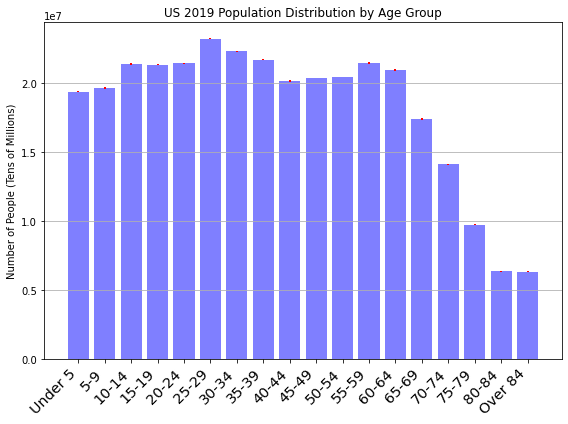

In [587]:
# population distribution by age group
plt.rcParams['figure.figsize'] = [8, 6]
x_labels = age_df.columns[2:]
x_pos = np.arange(len(x_labels))
y_vals = np.array(age_df.iloc[0, 2:], dtype=np.float32)
y_errs = np.array(age_df.iloc[1, 2:], dtype=np.float32)

fig, ax = plt.subplots()
ax.bar(x_pos, y_vals, align='center', alpha=0.5, color='blue', capsize=10)
ax.errorbar(x_pos, y_vals, yerr=y_errs, elinewidth=2, ecolor="red", ls='none')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
ax.set_ylabel('Number of People (Tens of Millions)')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_title('US 2019 Population Distribution by Age Group')
ax.yaxis.grid(True)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.tight_layout()

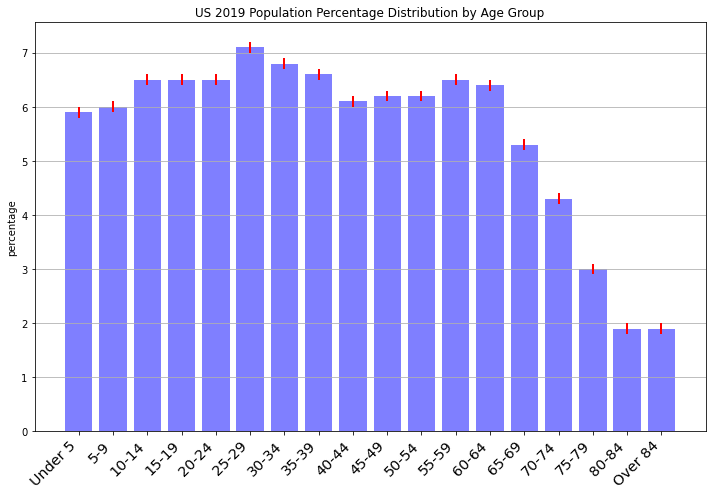

In [586]:
# population percentage distribution by age group
y_vals = np.array(age_df.iloc[2, 2:], dtype=np.float32) * 100
y_errs = np.array(age_df.iloc[3, 2:], dtype=np.float32)

fig, ax = plt.subplots()
ax.bar(x_pos, y_vals, align='center', alpha=0.5, color='blue', capsize=10)
ax.errorbar(x_pos, y_vals, yerr=y_errs, elinewidth=2, ecolor="red", ls='none')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
ax.set_ylabel('percentage')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_title('US 2019 Population Percentage Distribution by Age Group')
ax.yaxis.grid(True)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.tight_layout()




## Visualize Data on a Map

In [628]:
# shape file from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas
# edited using https://mapshaper.org/
bronx = shp.Reader("/content/drive/My Drive/ACS_2019/bronx_shape/bronx")

# data from https://data.census.gov/cedsci/table?q=dp03&g=860XX00US10451,10452,10453,10454,10455,10456,10457,10458, \ 
# 10459,10460,10461,10462,10463,10464,10465,10466,10467,10468,10469,10470,10471,10472,10473,10474,10475&tid=ACSDP5Y2019.DP03
bronx_econ_data = pd.read_csv("/content/drive/My Drive/ACS_2019/ACS_Bronx_Selected_Economic_Charicteristics.csv")

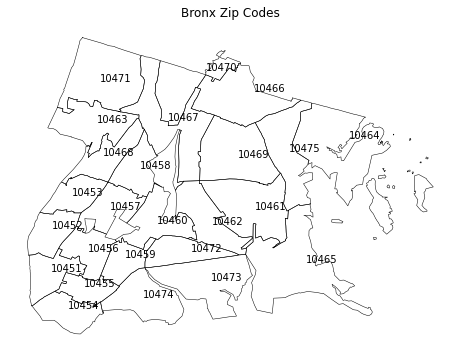

In [ ]:
text_pos = lambda x_coords, y_coords: (sum(x_coords)/len(x_coords), sum(y_coords)/len(y_coords))
zctas = [64, 70, 55, 73, 57, 63, 54, 68, 62, 65, 61, 51, 71, 67, 58, 72, 60, 56, 52, 69, 75, 66, 59, 53, 74] #last 2 digits of the zip code areas in the order that the they are drawn

plt.figure()
for id, shape in enumerate(bronx.shapeRecords()):
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i == len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        x = [i[0] for i in shape.shape.points[i_start:i_end]]
        y = [i[1] for i in shape.shape.points[i_start:i_end]]
        plt.plot(x,y, color="black", lw=0.5)
    plt.annotate(f"104{zctas[id]}", text_pos(x, y))
plt.title("Bronx Zip Codes")
plt.axis("off")
plt.rcParams['figure.figsize'] = [10, 7]
plt.show()

In [629]:
# separate data 
labels = bronx_econ_data["Label (Grouping)"]
employment_df = bronx_econ_data.loc[:, :"COMMUTING TO WORK"].drop("COMMUTING TO WORK", axis=1)
income_and_benefits_df = bronx_econ_data.loc[:, "INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)":"HEALTH INSURANCE COVERAGE"]

### Median Income

In [630]:
# isolate income data
median_income = income_and_benefits_df['INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)']
mean_income = income_and_benefits_df['INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Mean household income (dollars)']
income_df = pd.DataFrame(zip(list(labels), list(median_income), list(mean_income)), columns=['Labels', 'Median Household Income', 'Mean Household Income'])
for row in range(0, income_df.shape[0], 5):
  zcta = income_df.loc[row, 'Labels'].split()[1].strip()
  income_df.loc[row + 1, 'Labels'] = zcta + income_df.loc[row + 1, 'Labels']
income_df.loc[income_df['Labels'].str.contains("Estimate"), 'Median Household Income'] = income_df.loc[income_df['Labels'].str.contains("Estimate"), 'Median Household Income'].str.replace(',','').astype(float)
income_df.loc[income_df['Labels'].str.contains("Estimate"), 'Mean Household Income'] = income_df.loc[income_df['Labels'].str.contains("Estimate"), 'Mean Household Income'].str.replace(',','').astype(float)
income_df = income_df.loc[income_df['Labels'].str.contains("Estimate")]
income_df.head()

,Labels,Median Household Income,Mean Household Income
1,10451 Estimate,30349,49835
6,10452 Estimate,29579,41662
11,10453 Estimate,29136,41846
16,10454 Estimate,21447,39790
21,10455 Estimate,28585,42554


In [ ]:
def draw_bronx_with_colorbar(data, col, low, hi, title, cmlabels, cmtitle, cmcolors=["#fff", "#000"]):
  colormap = LinearSegmentedColormap.from_list("cm", [cmcolors[0], cmcolors[1]])
  for id, shape in enumerate(bronx.shapeRecords()):
      for i in range(len(shape.shape.parts)):
          i_start = shape.shape.parts[i]
          if i == len(shape.shape.parts)-1:
              i_end = len(shape.shape.points)
          else:
              i_end = shape.shape.parts[i+1]
          x = [i[0] for i in shape.shape.points[i_start:i_end]]
          y = [i[1] for i in shape.shape.points[i_start:i_end]]
          plt.plot(x,y, color="black", lw=0.5)
          metric = float(data.loc[data['Labels'].str.contains(f"104{zctas[id]}"), col])
          color_idx = (metric - low) / (hi - low)
          plt.fill(x,y, color=colormap(color_idx))
      plt.annotate(f"104{zctas[id]}", text_pos(x, y))
  plt.title(title)
  plt.axis("off")
  cbar = plt.colorbar(ScalarMappable(cmap=colormap), label=cmtitle, ticks=[0,1])
  cbar.ax.set_yticklabels([cmlabels[0], cmlabels[1]])
  plt.show()

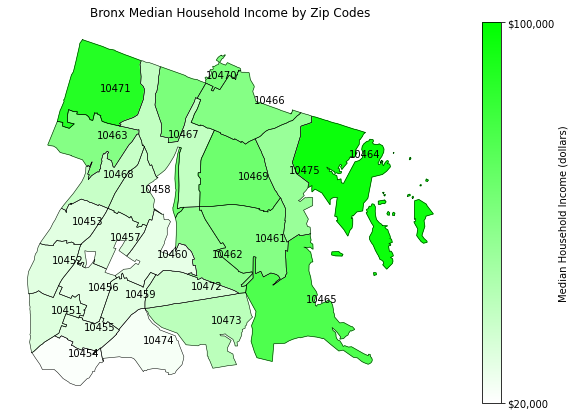

In [ ]:
draw_bronx_with_colorbar(
    income_df, 
    col="Median Household Income", 
    low=20000, 
    hi=100000, 
    title="Bronx Median Household Income by Zip Codes",
    cmlabels=['$20,000', '$100,000'],
    cmtitle="Median Household Income (dollars)",
    cmcolors=['#fff', '#0f0'],
)

### Unemployment

In [631]:
unemployment_rate = employment_df['EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate']
unemployment_df = pd.DataFrame(zip(list(labels), list(unemployment_rate)), columns=['Labels', 'Unemployment Rate'])
for row in range(0, unemployment_df.shape[0], 5):
  zcta = unemployment_df.loc[row, 'Labels'].split()[1]
  unemployment_df.loc[row + 3, 'Labels'] = zcta + ' Rate'
  unemployment_df.iloc[row + 3, 1:] = unemployment_df.iloc[row + 3, 1:].str.replace(percent_pat, percent_repl, regex=True).astype(float)
unemployment_df = unemployment_df.loc[unemployment_df['Labels'].str.contains("Rate")]
unemployment_df.head()

,Labels,Unemployment Rate
3,10451 Rate,0.078
8,10452 Rate,0.095
13,10453 Rate,0.13
18,10454 Rate,0.125
23,10455 Rate,0.134


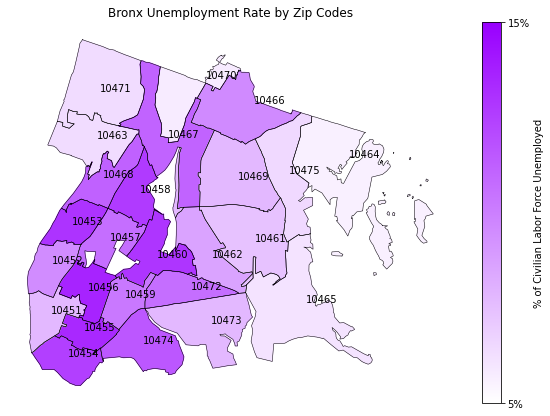

In [ ]:
draw_bronx_with_colorbar(
    unemployment_df, 
    col="Unemployment Rate", 
    low=0.05, 
    hi=0.15, 
    title="Bronx Unemployment Rate by Zip Codes",
    cmlabels=['5%', '15%'],
    cmtitle="% of Civilian Labor Force Unemployed",
    cmcolors=['#fff', '#90f'],
)

### Housing Density

In [ ]:
# data from https://data.census.gov/cedsci/table?q=housing%20units&g=860XX00US10451,10452,10453,10454,10455,10456,10457,10458, \
# 10459,10460,10461,10462,10463,10464,10465,10466,10467,10468,10469,10470,10471,10472,10473,10474,10475&tid=DECENNIALSF12010.H1&tp=false
bronx_housing_units_data = pd.read_csv("/content/drive/My Drive/ACS_2019/Housing_Density/ACS2019_Bronx_Housing.csv", encoding= 'unicode_escape')

for row in range(0, bronx_housing_units_data.shape[0], 3):
  zcta = bronx_housing_units_data.loc[row, 'Labels'].split()[1]
  bronx_housing_units_data.loc[row + 1, 'Labels'] = zcta
bronx_housing_units_data = bronx_housing_units_data.loc[bronx_housing_units_data['Total Housing Units'].str.contains(",") == True]
bronx_housing_units_data['Total Housing Units'] = bronx_housing_units_data['Total Housing Units'].apply(lambda s: s.replace(',', '')).astype(float)
bronx_housing_units_data.set_index(np.arange(25), inplace=True)

In [ ]:
# data from https://data.census.gov/cedsci/table?q=population%202019&g=860XX00US10451,10452,10453,10454,10455,10456,10457,10458, \
# 10459,10460,10461,10462,10463,10464,10465,10466,10467,10468,10469,10470,10471,10472,10473,10474,10475
bronx_pop_data = pd.read_csv("/content/drive/My Drive/ACS_2019/Housing_Density/ACS2019_Bronx_Population.csv")

for row in range(0, bronx_pop_data.shape[0], 2):
  zcta = bronx_pop_data.iloc[row, 0].split()[1]
  bronx_pop_data.iloc[row + 1, 0] = zcta
bronx_pop_data = bronx_pop_data.loc[bronx_pop_data['Total'].str.contains(",") == True]
bronx_pop_data['Total'] = bronx_pop_data['Total'].apply(lambda s: s.replace(',', '')).astype(float)
bronx_pop_data.set_index(np.arange(25), inplace=True)

In [ ]:
# data from https://data.census.gov/cedsci/table?q=vacant%20houses%202019&g=860XX00US10451,10452,10453,10454,10455,10456,10457,10458, \
# 10459,10460,10461,10462,10463,10464,10465,10466,10467,10468,10469,10470,10471,10472,10473,10474,10475&tid=ACSDT5Y2019.B25005&moe=false&tp=true
bronx_vacant_units_data = pd.read_csv("/content/drive/My Drive/ACS_2019/Housing_Density/ACS2019_Bronx_Vacant_Units.csv")

for row in range(0, bronx_vacant_units_data.shape[0], 2):
  zcta = bronx_vacant_units_data.iloc[row, 0].split()[1]
  bronx_vacant_units_data.iloc[row + 1, 0] = zcta
bronx_vacant_units_data = bronx_vacant_units_data.loc[bronx_vacant_units_data['Labels'].str.contains("ZCTA5") == False]
bronx_vacant_units_data['Vacant Units'] = bronx_vacant_units_data['Vacant Units'].apply(lambda s: s.replace(',', '')).astype(float)
bronx_vacant_units_data.set_index(np.arange(25), inplace=True)

In [625]:
housing_density_df = pd.DataFrame({
    'Labels': bronx_vacant_units_data['Labels'],
    'Occupied Units': bronx_housing_units_data['Total Housing Units'] - bronx_vacant_units_data['Vacant Units'],
    'Population': bronx_pop_data['Total']
})
housing_density_df['People Per House'] = housing_density_df['Population'] / housing_density_df['Occupied Units']
housing_density_df.head()

,Labels,Occupied Units,Population,People Per House
0,10451,19522.0,48136.0,2.465731
1,10452,26437.0,75452.0,2.854030
2,10453,27774.0,81716.0,2.942176
3,10454,13429.0,37212.0,2.771018
4,10455,14427.0,41951.0,2.907812


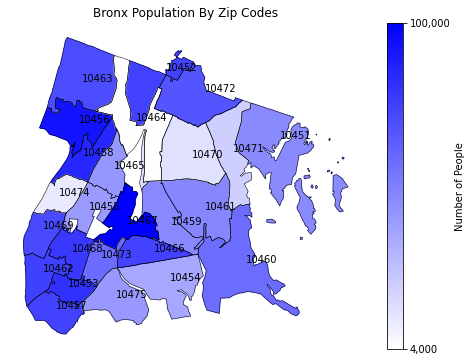

In [594]:
draw_bronx_with_colorbar(
    housing_density_df, 
    col="Population", 
    low=4000, 
    hi=100000, 
    title="Bronx Population By Zip Codes",
    cmlabels=['4,000', '100,000'],
    cmtitle="Number of People",
    cmcolors=['#fff', '#00f'],
)

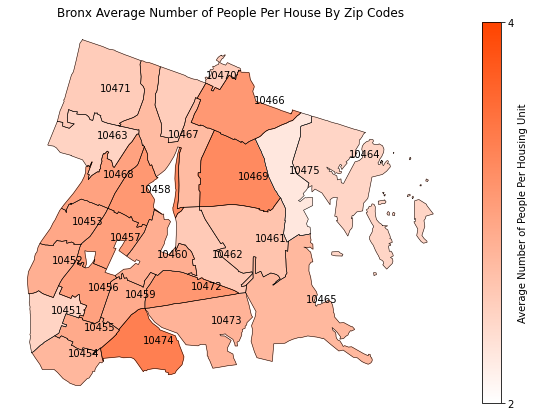

In [ ]:
draw_bronx_with_colorbar(
    housing_density_df, 
    col="People Per House", 
    low=2, 
    hi=4, 
    title="Bronx Average Number of People Per House By Zip Codes",
    cmlabels=['2', '4'],
    cmtitle="Average Number of People Per Housing Unit",
    cmcolors=['#fff', '#f40'],
)

## Mortgage Data

In [620]:
# data from https://data.census.gov/cedsci/table?q=with%20a%20mortgage%202019&g=860XX00US10451,10452,10453,10454,10455,10456,10457,10458, \
# 10459,10460,10461,10462,10463,10464,10465,10466,10467,10468,10469,10470,10471,10472,10473,10474,10475&tid=ACSDT5Y2019.B25081&moe=true&tp=true
mortgage_df = pd.read_csv("/content/drive/My Drive/ACS_2019/ACS2019_Bronx_Mortgage.csv")
mortgage_df.columns = ['Labels', 'Total', 'Units With Mortgage', 'Second Mortgage or HELOC', 'Only Second Mortgage', 'Only HELOC', 'Second Mortgage and HELOC', 'No Second Mortgage or HELOC', 'No Mortgage']

for row in range(0, mortgage_df.shape[0], 3):
  zcta = mortgage_df.at[row, 'Labels'].split()[1]
  mortgage_df.at[row + 1, 'Labels'] = zcta + " Estimate"
  mortgage_df.at[row + 2, 'Labels'] = zcta + " Error"
mortgage_df = mortgage_df.loc[mortgage_df['Labels'].str.contains("ZCTA5") == False]
mortgage_df.loc[:, 'Total':'No Mortgage'] = mortgage_df.loc[:, 'Total':'No Mortgage'].replace(",|±", "", regex=True).astype(float)
mortgage_df.head()

,Labels,Total,Units With Mortgage,Second Mortgage or HELOC,Only Second Mortgage,Only HELOC,Second Mortgage and HELOC,No Second Mortgage or HELOC,No Mortgage
1,10451 Estimate,2116,911,69,25,44,0,842,1205
2,10451 Error,265,207,68,30,52,25,193,222
4,10452 Estimate,788,373,43,43,0,19,311,415
5,10452 Error,181,155,52,52,28,29,150,132
7,10453 Estimate,1074,630,51,0,51,0,579,444


In [579]:
# extract data for bar chart
bar_labels = [zcta.split()[0] for zcta in mortgage_df.loc[1::2, 'Labels']]
total_units = np.array(mortgage_df.loc[1::2,'Total'], dtype=np.float32)
units_with_mortgage = np.array(mortgage_df.loc[1::2, 'Units With Mortgage'], dtype=np.float32)
second_mortgage_or_heloc = np.array(mortgage_df.loc[1::2, 'Second Mortgage or HELOC'], dtype=np.float32)
only_second_mortgage = np.array(mortgage_df.loc[1::2, 'Only Second Mortgage'], dtype=np.float32)
only_heloc = np.array(mortgage_df.loc[1::2, 'Only HELOC'], dtype=np.float32)
second_mortgage_and_heloc = np.array(mortgage_df.loc[1::2, 'Second Mortgage and HELOC'], dtype=np.float32)
neither = np.array(mortgage_df.loc[1::2, 'No Second Mortgage or HELOC'], dtype=np.float32)
no_mortgage = np.array(mortgage_df.loc[1::2, 'No Mortgage'], dtype=np.float32)

total_units_err = np.array(mortgage_df.loc[2::2,'Total'], dtype=np.float32)
units_with_mortgage_err = np.array(mortgage_df.loc[2::2, 'Units With Mortgage'], dtype=np.float32)
second_mortgage_or_heloc_err = np.array(mortgage_df.loc[2::2, 'Second Mortgage or HELOC'], dtype=np.float32)
only_second_mortgage_err = np.array(mortgage_df.loc[2::2, 'Only Second Mortgage'], dtype=np.float32)
only_heloc_err = np.array(mortgage_df.loc[2::2, 'Only HELOC'], dtype=np.float32)
second_mortgage_and_heloc_err = np.array(mortgage_df.loc[2::2, 'Second Mortgage and HELOC'], dtype=np.float32)
neither_err = np.array(mortgage_df.loc[2::2, 'No Second Mortgage or HELOC'], dtype=np.float32)
no_mortgage_err = np.array(mortgage_df.loc[2::2, 'No Mortgage'], dtype=np.float32)

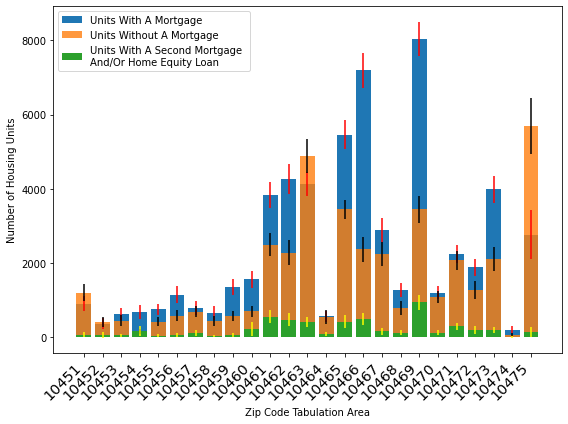

In [619]:
fig, ax = plt.subplots()

ax.bar(bar_labels, units_with_mortgage, yerr=units_with_mortgage_err, label="Units With A Mortgage", ecolor="red")
ax.bar(bar_labels, no_mortgage, yerr=no_mortgage_err, label="Units Without A Mortgage", alpha=0.8)
ax.bar(bar_labels, (second_mortgage_or_heloc + second_mortgage_and_heloc), yerr=(second_mortgage_or_heloc_err + second_mortgage_and_heloc), 
       label="Units With A Second Mortgage \nAnd/Or Home Equity Loan", ecolor="yellow")

ax.legend()
ax.set_ylabel("Number of Housing Units")
ax.set_xlabel("Zip Code Tabulation Area")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.tight_layout()